In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl


In [23]:
# Imports
import os
import pandas as pd
import numpy as np
import torch
import time
import pickle
from datasets import Dataset, load_dataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from peft import get_peft_model, LoraConfig, TaskType
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
MODEL_NAME = "roberta-base"
NUM_LABELS = 4
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
SEED = 42

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load Test Set
with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f:
    test_data = pickle.load(f)

test_df = pd.DataFrame(test_data)
test_df["text"] = test_df["text"].astype(str)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize Function
def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

tokenized_test = test_dataset.map(tokenize_fn, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [4]:
# Load Base Model and Wrap with LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(base_model, lora_config)
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Load AG News Dataset
dataset = load_dataset("ag_news")
split = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
train_ds = split["train"]
val_ds = split["test"]

tokenized_train = train_ds.map(tokenize_fn, batched=True)
tokenized_val = val_ds.map(tokenize_fn, batched=True)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 888580


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [5]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"eval_accuracy": acc}

# Label Smoothing Trainer
class LabelSmoothingTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(label_smoothing=0.1)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Callback to Print Metrics Simply
class SimpleLoggerCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # Every 100 steps, run eval manually
        if state.global_step % 1000 == 0:
            logs = kwargs["logs"] if "logs" in kwargs else {}
            control.should_evaluate = True  

    def on_log(self, args, state, control, logs=None, **kwargs):
        step = state.global_step
        train_loss = logs.get("loss", None)
        val_loss = logs.get("eval_loss", None)
        val_acc = logs.get("eval_accuracy", None)

        if train_loss is not None:
            print(f"Step {step} | Training Loss: {train_loss:.4f}")

        if val_loss is not None or val_acc is not None:
            msg = f"Step {step}"
            if val_loss is not None:
                msg += f" | Validation Loss: {val_loss:.4f}"
            if val_acc is not None:
                msg += f" | Validation Accuracy: {val_acc:.4f}"
            print(msg)

In [6]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-5,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs",
    logging_steps=1000,
    eval_steps=1000,              # evaluation every 1000 steps
    logging_strategy="steps",   
    save_strategy="no",         # no checkpoints saved
    do_eval=True,
    report_to="none",
    seed=SEED
)

# Trainer
trainer = LabelSmoothingTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[SimpleLoggerCallback()]
)

/tmp/ipykernel_31/460456359.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LabelSmoothingTrainer.__init__`. Use `processing_class` instead.
  trainer = LabelSmoothingTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [7]:
# Train
train_output = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,1.181300,0.585994,0.885250
2000,0.564800,0.554494,0.900500
3000,0.552600,0.541813,0.909250
4000,0.541700,0.532398,0.909833
5000,0.532600,0.527929,0.915250
6000,0.528800,0.519926,0.916583
7000,0.526100,0.521257,0.918833
8000,0.517400,0.521311,0.918750
9000,0.520200,0.519127,0.920250
10000,0.516700,0.513535,0.922000


Step 1000 | Training Loss: 1.1813
Step 1000 | Validation Loss: 0.5860 | Validation Accuracy: 0.8852
Step 2000 | Training Loss: 0.5648
Step 2000 | Validation Loss: 0.5545 | Validation Accuracy: 0.9005
Step 3000 | Training Loss: 0.5526
Step 3000 | Validation Loss: 0.5418 | Validation Accuracy: 0.9093
Step 4000 | Training Loss: 0.5417
Step 4000 | Validation Loss: 0.5324 | Validation Accuracy: 0.9098
Step 5000 | Training Loss: 0.5326
Step 5000 | Validation Loss: 0.5279 | Validation Accuracy: 0.9153
Step 6000 | Training Loss: 0.5288
Step 6000 | Validation Loss: 0.5199 | Validation Accuracy: 0.9166
Step 7000 | Training Loss: 0.5261
Step 7000 | Validation Loss: 0.5213 | Validation Accuracy: 0.9188
Step 8000 | Training Loss: 0.5174
Step 8000 | Validation Loss: 0.5213 | Validation Accuracy: 0.9187
Step 9000 | Training Loss: 0.5202
Step 9000 | Validation Loss: 0.5191 | Validation Accuracy: 0.9203
Step 10000 | Training Loss: 0.5167
Step 10000 | Validation Loss: 0.5135 | Validation Accuracy: 0.922

In [8]:
# Final Eval
eval_metrics = trainer.evaluate()
print(f"\n Final Validation Accuracy: {eval_metrics['eval_accuracy']:.4f}")
print(f" Final Validation Loss: {eval_metrics['eval_loss']:.4f}")

Step 20250 | Validation Loss: 0.5009 | Validation Accuracy: 0.9252

 Final Validation Accuracy: 0.9252
 Final Validation Loss: 0.5009


In [9]:
# Predict on Test Set
preds = trainer.predict(tokenized_test)
pred_labels = np.argmax(preds.predictions, axis=1)

In [10]:
print(test_df.columns)

Index(['text'], dtype='object')


In [11]:
# Prepare Submission
submission_df = pd.DataFrame({
    "ID": test_df.index,
    "Label": pred_labels
})
submission_df.to_csv("/kaggle/working/submission.csv", index=False)
submission_df.head()

,ID,Label
0,0,3
1,1,0
2,2,0
3,3,3
4,4,1


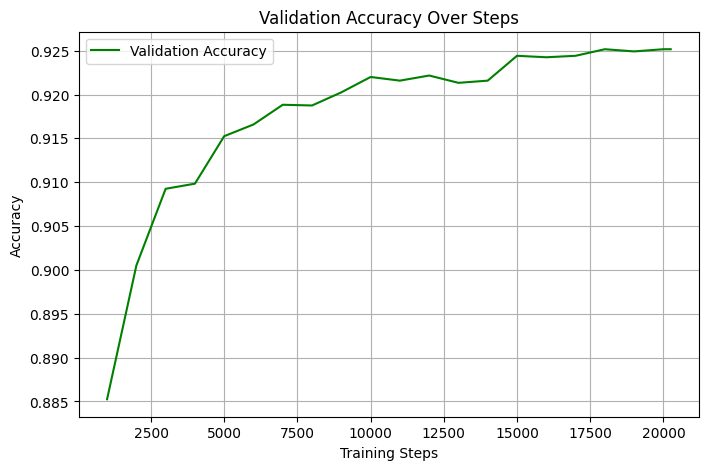

In [16]:
logs = trainer.state.log_history
val_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
val_steps = [log["step"] for log in logs if "eval_accuracy" in log]

plt.figure(figsize=(8, 5))
plt.plot(val_steps, val_acc, label="Validation Accuracy", color='green')
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Steps")
plt.grid(True)
plt.legend()
plt.show()

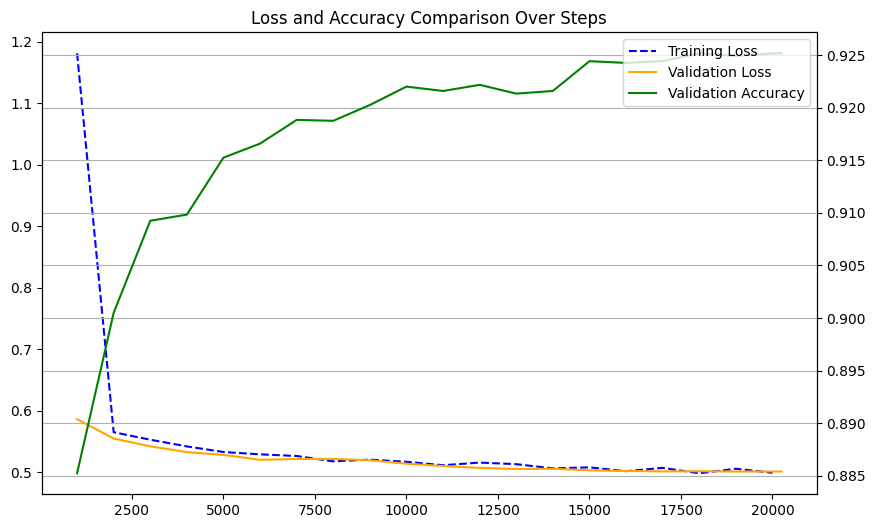

In [20]:
plt.figure(figsize=(10, 6))

# Plot Losses
line1, = plt.plot(train_steps, train_loss, label="Training Loss", color='blue', linestyle='--')
line2, = plt.plot(val_steps, val_loss, label="Validation Loss", color='orange')

# Plot Accuracy on second y-axis
ax2 = plt.gca().twinx()
line3, = ax2.plot(val_steps, val_acc, label="Validation Accuracy", color='green')

# Title and Labels
plt.title("Loss and Accuracy Comparison Over Steps")
plt.xlabel("Training Steps")
plt.grid(True)

# Combine and Match Legend Labels
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right')

plt.show()

<Figure size 800x600 with 0 Axes>

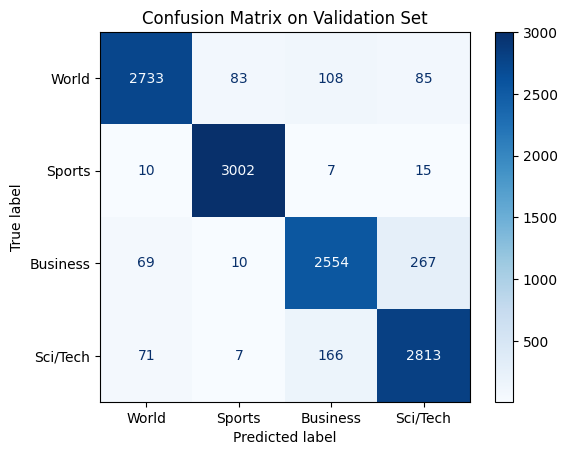

In [21]:
# Get predictions and labels
predictions = trainer.predict(tokenized_val)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
# Class names from AG News
labels = ["World", "Sports", "Business", "Sci/Tech"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

       World       0.95      0.91      0.93      3009
      Sports       0.97      0.99      0.98      3034
    Business       0.90      0.88      0.89      2900
    Sci/Tech       0.88      0.92      0.90      3057

    accuracy                           0.93     12000
   macro avg       0.93      0.92      0.92     12000
weighted avg       0.93      0.93      0.93     12000



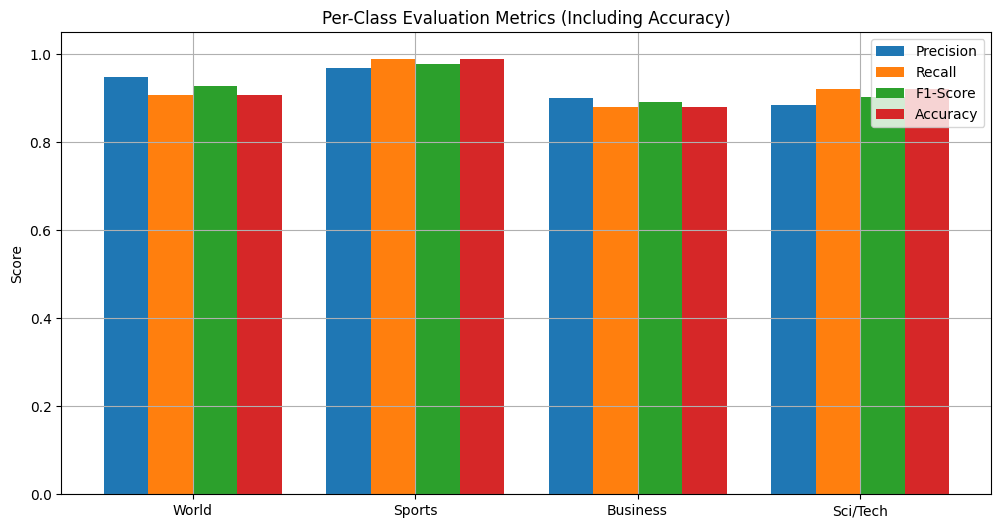

In [24]:
print(classification_report(y_true, y_pred, target_names=["World", "Sports", "Business", "Sci/Tech"]))

# Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
classes = ["World", "Sports", "Business", "Sci/Tech"]

# Accuracy per class
total_per_class = np.bincount(y_true, minlength=len(classes))
correct_per_class = np.bincount(y_true[y_true == y_pred], minlength=len(classes))
accuracy = correct_per_class / total_per_class

# Bar plot
x = np.arange(len(classes))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, precision, width, label='Precision')
plt.bar(x - 0.5*width, recall, width, label='Recall')
plt.bar(x + 0.5*width, f1, width, label='F1-Score')
plt.bar(x + 1.5*width, accuracy, width, label='Accuracy')

plt.xticks(x, classes)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Per-Class Evaluation Metrics (Including Accuracy)")
plt.legend()
plt.grid(True)
plt.show()